## Loading several helpful packeges.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split

#    nltk используем для оценки текста комментария
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

#    Используем Counter для подсчета популярных тегов средствами Python, а не Pandas
#    LabelEncoder используем для передачи номинальных категориальных признаков в модель напрямую
from collections import Counter
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

#    Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

import category_encoders as ce # импортируем библиотеку для работы с кодировщиками

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
#    Фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [3]:
#    Фиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
#    Подгрузим наши данные из соревнования
# DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv('hotels_train.csv', sep=',') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv', sep=',') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv', sep=',') # самбмишн

In [5]:
#df_train.info()

In [6]:
#df_train.head(2)

In [7]:
#df_test.info()

In [8]:
#df_test.head(2)

In [9]:
#sample_submission.info()

In [10]:
#sample_submission.head(2)

In [5]:
df_train.shape

(386803, 17)

In [6]:
df_train[df_train.duplicated() == True].shape

(307, 17)

In [7]:
# Уберем полные дубликаты
df_train.drop_duplicates(inplace=True)
df_train.shape

(386496, 17)

## Combine the train and the test into one dataset.

In [8]:
# дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

<AxesSubplot:>

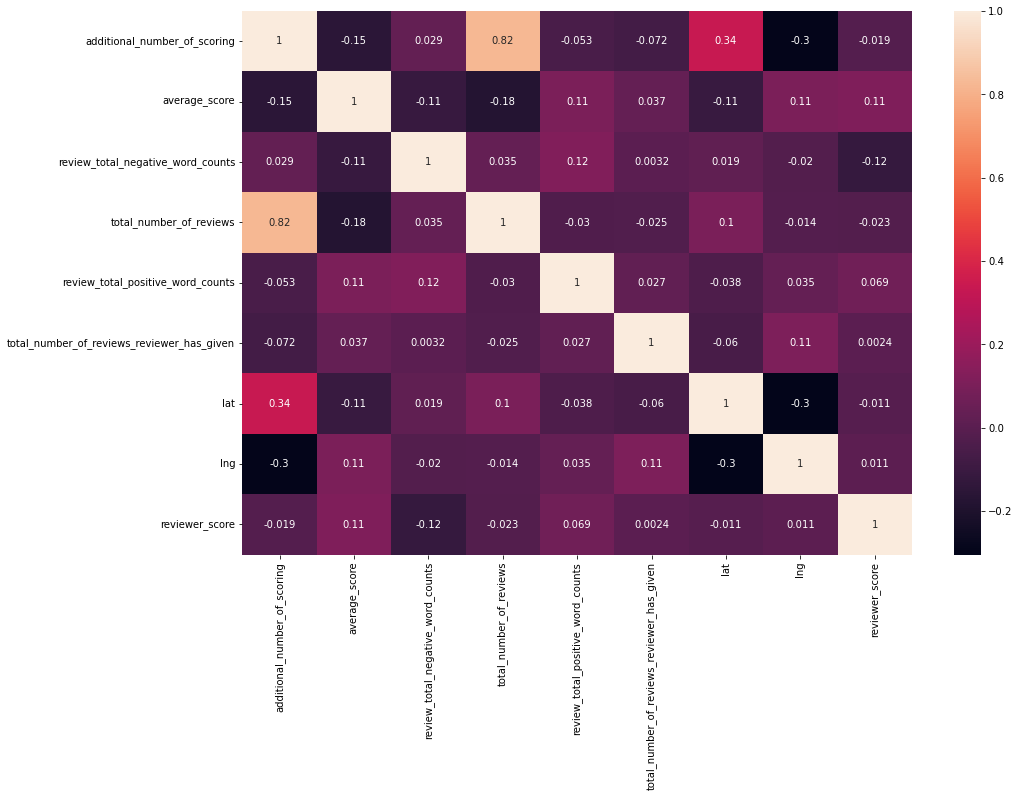

In [9]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),annot=True)

In [10]:
!pip install nltk

## Обрабатываем признаки датасета

In [11]:
%%time
#    Поработаем с текстом комментариев:
#    Часто в отзывах можно встретить слово 'nothing' либо похожие вариации, что можно расценить, 
#    как положительный отзыв в признаке 'negative_review' или отрицательный отзыв в признаке 'negative_review'
#    Воспользуемся этим для создания новых признаков и удалим их в исходных признаках
#    Наиболее частые вариации таких случаев представлены в словаре
#    Затем пересчитаем поля "количество слов в плохих/хороших комментариях"
#    Также создадим новый признак - разница между размеров комментариев
#    Дополнительно оценим полярность комментариев с помощью пакета nltk, дополнив датафрейм новыми признаками
replace = {    
    'positive_review': ['no positive','nothing'],
    'negative_review': [
        'nothing really','no negative','nothing','n a','none','nothing at all','nothing to dislike',
        'everything was perfect','na','can t think of anything','nil','everything was great','absolutely nothing',
        'nothing to complain about','no','nothing not to like','nothing all good','no complaints','i liked everything'
        ,'liked everything']
}
data['no_neg'] = 0
data['no_pos'] = 0
for key in replace:
    for value in replace['positive_review']:
        data.loc[data['positive_review'].str.strip().str.lower()==value,'no_pos'] = 1
        data.loc[data['positive_review'].str.strip().str.lower()=='everything','no_neg'] = 1
        data.loc[data['positive_review'].str.strip().str.lower()==value, 'positive_review'] = ''
    for value in replace['negative_review']:
        data.loc[data['negative_review'].str.strip().str.lower()==value,'no_neg'] = 1
        data.loc[data['negative_review'].str.strip().str.lower()=='everything','no_pos'] = 1
        data.loc[data['negative_review'].str.strip().str.lower()==value, 'negative_review'] = ''
        
data['review_total_positive_word_counts'] = data['positive_review'].apply(lambda s: len(s.strip().split(' ')))
data['review_total_negative_word_counts'] = data['negative_review'].apply(lambda s: len(s.strip().split(' ')))
data['review_diff'] = data['positive_review'].str.len() - data['negative_review'].str.len()

sent_analyzer = SentimentIntensityAnalyzer()
# Анализируем отзывы
data['rw_neg'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['rw_pos'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
# Записываем результаты в основной датафрейм в виде отдельных признаков
data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['rw_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['rw_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

#    Поскольку отель встречается несколько раз, делаем из него номинальный признак
data['hotel_name'] = LabelEncoder().fit_transform(data['hotel_name'])

#    Выделяем страну, город и почтовый индекс из адреса отеля
data['city'] = data.hotel_address.apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])
data['country'] = data.hotel_address.apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])
data['zip'] = data['hotel_address'].apply(lambda x: x.split()[-4] + ' ' + x.split()[-3] if x.endswith(
    'United Kingdom') or x.endswith('Netherlands') else x.split()[-3])
data.drop('hotel_address',axis = 1, inplace = True)

#    Добавляем население города https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits
сity_population = {
    'Paris': 2139907, 'London': 9002488, 'Milan': 1374582, 
    'Vienna': 1931830, 'Barcelona': 1636732, 'Amsterdam': 905234
}
data['сity_population'] = data['city'].map(сity_population)

#    Добавляем население страны https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population
country_population = {
    'United Kingdom':67108596,'Netherlands':17706531,'France':67422241,
    'Spain':47326687,'Italy':58983122,'Austria':8979894
}
data['country_population'] = data['country'].map(country_population)

data['%_city_pop_from_country_pop'] = data['сity_population'] / data['country_population']

#    Кодируем индекс с помощью LabelEncoder
data['zip'] = LabelEncoder().fit_transform(data['zip'])

#    Преобразуем координаты следующим образом:
#    Расчитаем минимальное, максимальное и среднее значение широты и долготы, для каждого города.
#    Заменим пропуски на среднее значение
#    Выполним операцию MinMaxScaler, с учетом каждого города 
#    вычтем из координаты отеля минимальную широту и долготу соответственно для его города
#    разделим на разницу между максимальным и минимальным значение координаты
#    Значения широта и долгота примут значения от 0 до 1 для каждого города

average_coords = dict(data.groupby('city')[['lat','lng']].agg(['min','mean','max']))
def align_coord_to_center(row,key,avg):
    value = row[key]
    if np.isnan(row[key]):
        value = avg[(key,'mean')][row['city']]
    result = (value - avg[(key,'min')][row['city']]) / (avg[(key,'max')][row['city']] - avg[(key,'min')][
        row['city']])
    return result

data['lat'] = data.apply(align_coord_to_center,axis = 1,key = 'lat',avg = average_coords)
data['lng'] = data.apply(align_coord_to_center,axis = 1,key = 'lng',avg = average_coords)

#    Преобразуем город отеля в бинарные признаки методом OneHotEncoding, удалим исходный признак
data = pd.concat([data,pd.get_dummies(data['city'], drop_first = True)],axis=1)
data.drop(['city', 'country'],axis = 1, inplace = True)

#    Оставим признак - возраст комментария в числовом виде для передачи в модель
data['days_since_review'] = data['days_since_review'].apply(lambda s: s.split(' ')[0]).astype('int')

#    Из даты оставим также месяц и день недели
data['review_date'] = pd.to_datetime(data['review_date'])
data['month'] = pd.to_datetime(data['review_date']).dt.month
data['weekday'] = pd.to_datetime(data['review_date']).dt.weekday
data.drop('review_date',axis = 1, inplace = True)

#    Из множества национальностей автора отзыва оставим наиболее популярные, остальные соберем в группу Other 
#    и закодируем методом OneHotEncoding
allowed_nationalities = ['United Kingdom', 'United States of America', 'Australia', 'Ireland']
data = pd.concat([data,pd.get_dummies(data['reviewer_nationality'].str.strip().apply(lambda s: s if s in allowed_nationalities else 'Other'),
                                      prefix = 'From ',drop_first=True)], axis = 1)
data.drop('reviewer_nationality',axis = 1, inplace = True)

#Из всего набора тегов оставим 10 наиболее популярных в виде бинарных признаков
TAGS_NUMBER = 11
c = Counter()
for tags in data['tags'].apply(lambda s: [x.strip() for x in s[1:-1].replace("'",'').split(',')]):
    for tag in tags:
        c[tag] += 1
for tag , _ in c.most_common(TAGS_NUMBER):
    tag_name = tag.lower().replace(' ','_')
    data[f"tag_{tag_name}"] = data['tags'].apply(lambda tags: int(tag in tags))        
data.drop(['tags'],axis = 1, inplace = True)

Wall time: 10min 16s


In [12]:
display(data.iloc[:, 11:30].head())

,lng,sample,reviewer_score,no_neg,no_pos,review_diff,rw_neg,rw_pos,n_neg,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound,zip,сity_population,country_population
0,0.543568,0,0.0,0,0,75,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...","{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",0.129,0.747,0.125,-0.0554,0.0,0.671,0.329,0.9615,187,1374582,58983122
1,0.093151,0,0.0,0,1,-44,"{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.216,0.784,0.000,-0.2960,0.0,0.000,0.000,0.0000,87,905234,17706531
2,0.508333,0,0.0,0,0,18,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...",0.000,1.000,0.000,0.0000,0.0,0.260,0.740,0.6908,7,1636732,47326687
3,0.677381,0,0.0,1,0,155,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...",0.000,0.000,0.000,0.0000,0.0,0.621,0.379,0.9153,158,1374582,58983122
4,0.396827,0,0.0,1,0,32,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.23, 'pos': 0.77, 'compou...",0.000,0.000,0.000,0.0000,0.0,0.230,0.770,0.7717,52,905234,17706531


In [13]:
#    Для сравнения степени влияния признаков на целевую переменную воспользуемся тестами
#    Хи-квадрат для категориальных переменных
#    ANOVA для числовых переменных
#    Дальнейшее удаление признаков приводит к ухудшению итогового значения MAPE

from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
cat_cols = [
    'Paris', 'London', 'Milan', 'Vienna', 'Barcelona', 'month','weekday', 'tag_leisure_trip', 'tag_submitted_from_a_mobile_device', 'tag_couple', 
    'tag_stayed_1_night', 'tag_stayed_2_nights', 'tag_solo_traveler', 'tag_stayed_3_nights', 'tag_business_trip', 'tag_group', 
    'tag_family_with_young_children', 'tag_stayed_4_nights', 'From _Ireland', 'From _Other', 'From _United Kingdom', 
    'From _United States of America', 'hotel_name', 'zip', 'no_pos', 'no_neg'
]
num_cols = [
    'additional_number_of_scoring','average_score','review_total_negative_word_counts','total_number_of_reviews',
    'review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given','days_since_review','lat','lng',
    'review_diff', '%_city_pop_from_country_pop', 'сity_population', 'country_population',
    'n_neg', 'n_neu', 'n_pos', 'n_compound', 'p_neg', 'p_neu', 'p_pos', 'p_compound'
]

<AxesSubplot:>

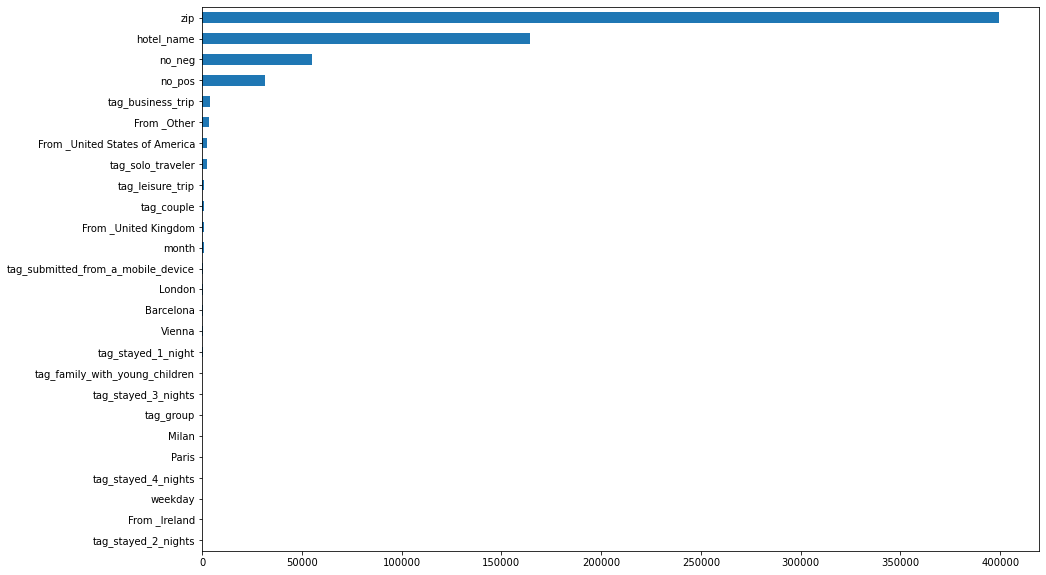

In [14]:
#    нужно предварительно отделить train от test
train_data = data.query('sample == 1')
test_data = data.query('sample == 0')
plt.rcParams['figure.figsize'] = (15,10)
cat_att = pd.Series(chi2(train_data[cat_cols],train_data['reviewer_score'].astype('int'))[0],index=cat_cols)
cat_att.sort_values(ascending=True).plot(kind='barh')

<AxesSubplot:>

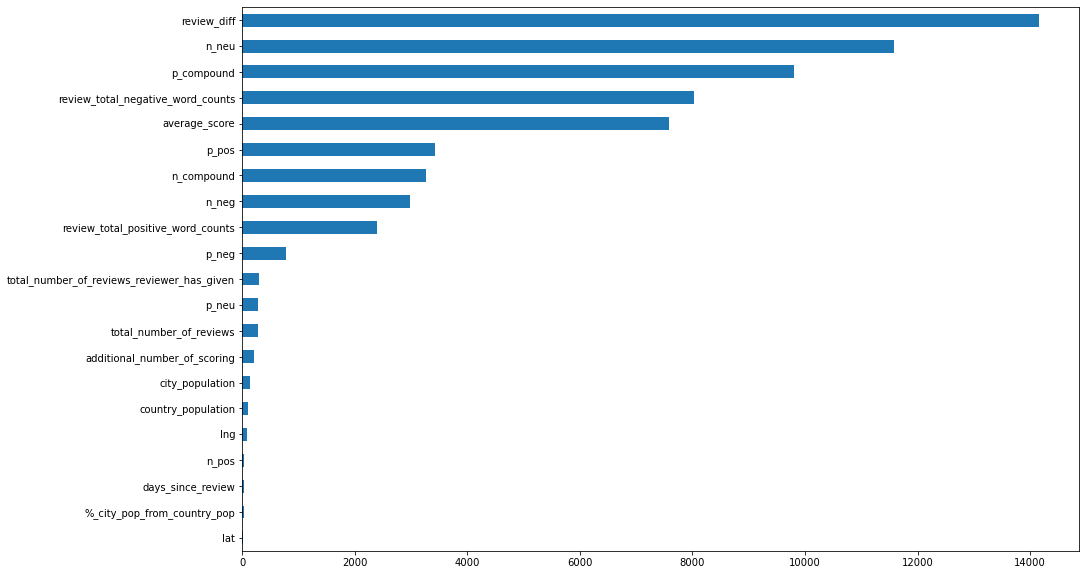

In [15]:
plt.rcParams['figure.figsize'] = (15,10)
num_att = pd.Series(f_classif(train_data[num_cols],train_data['reviewer_score'].astype('int'))[0],index=num_cols)
num_att.sort_values(ascending=True).plot(kind='barh')

<AxesSubplot:>

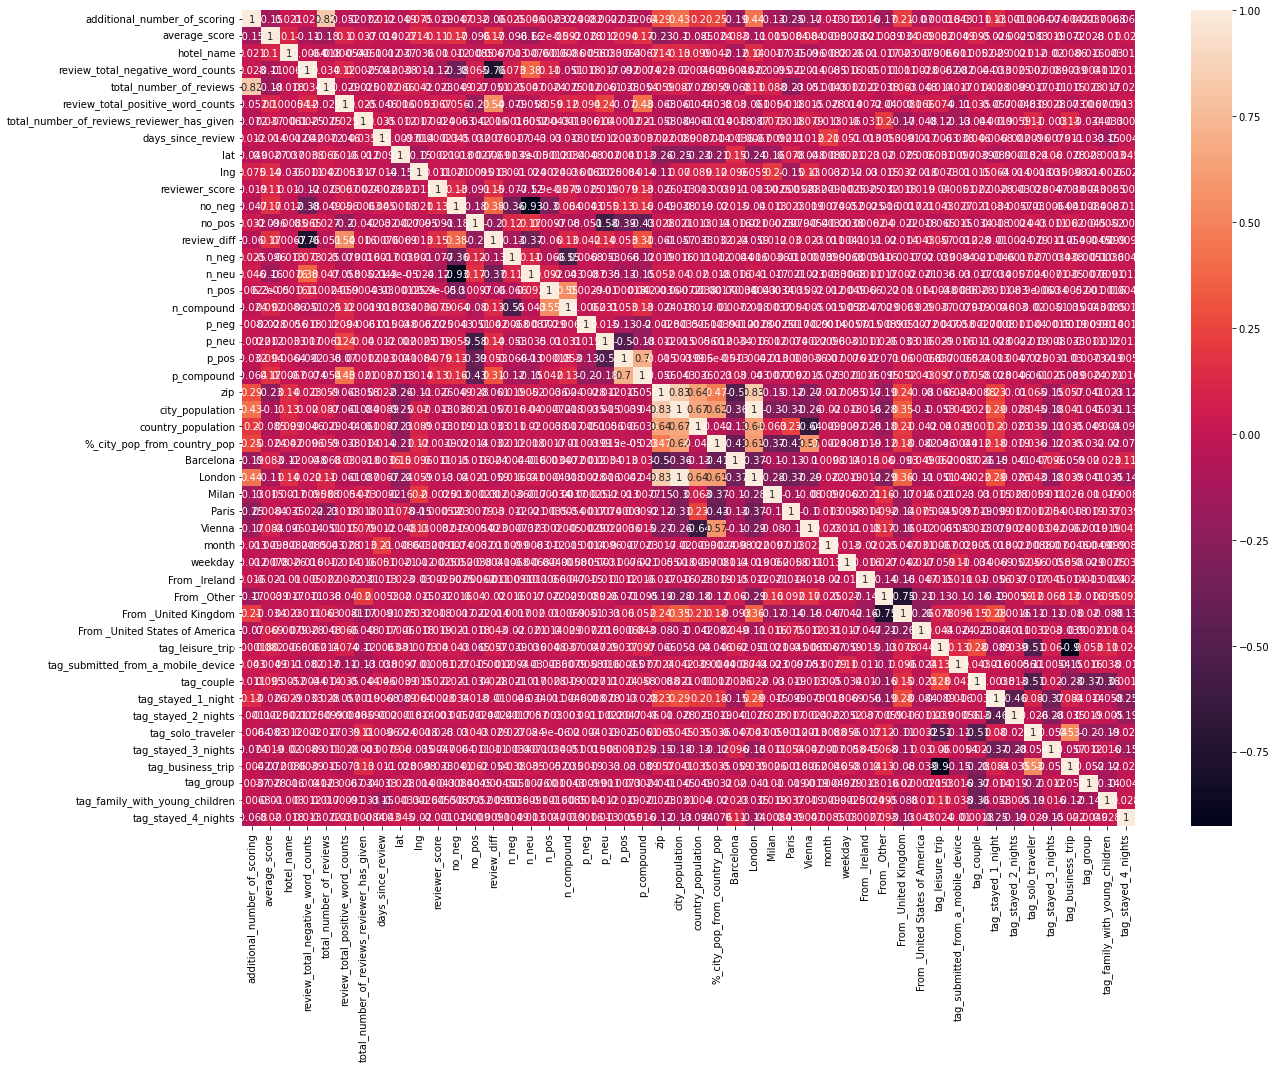

In [16]:
plt.rcParams['figure.figsize'] = (20,15)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [18]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим при наличии таковых
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [19]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
len(object_columns)

0

In [20]:
#data.to_csv('data_v_fin.csv', index=False)

In [26]:
#data = pd.read_csv('data_v_fin.csv', sep=',')

In [21]:
data = data.drop(['additional_number_of_scoring', 'сity_population', 'London'], axis=1)

<AxesSubplot:>

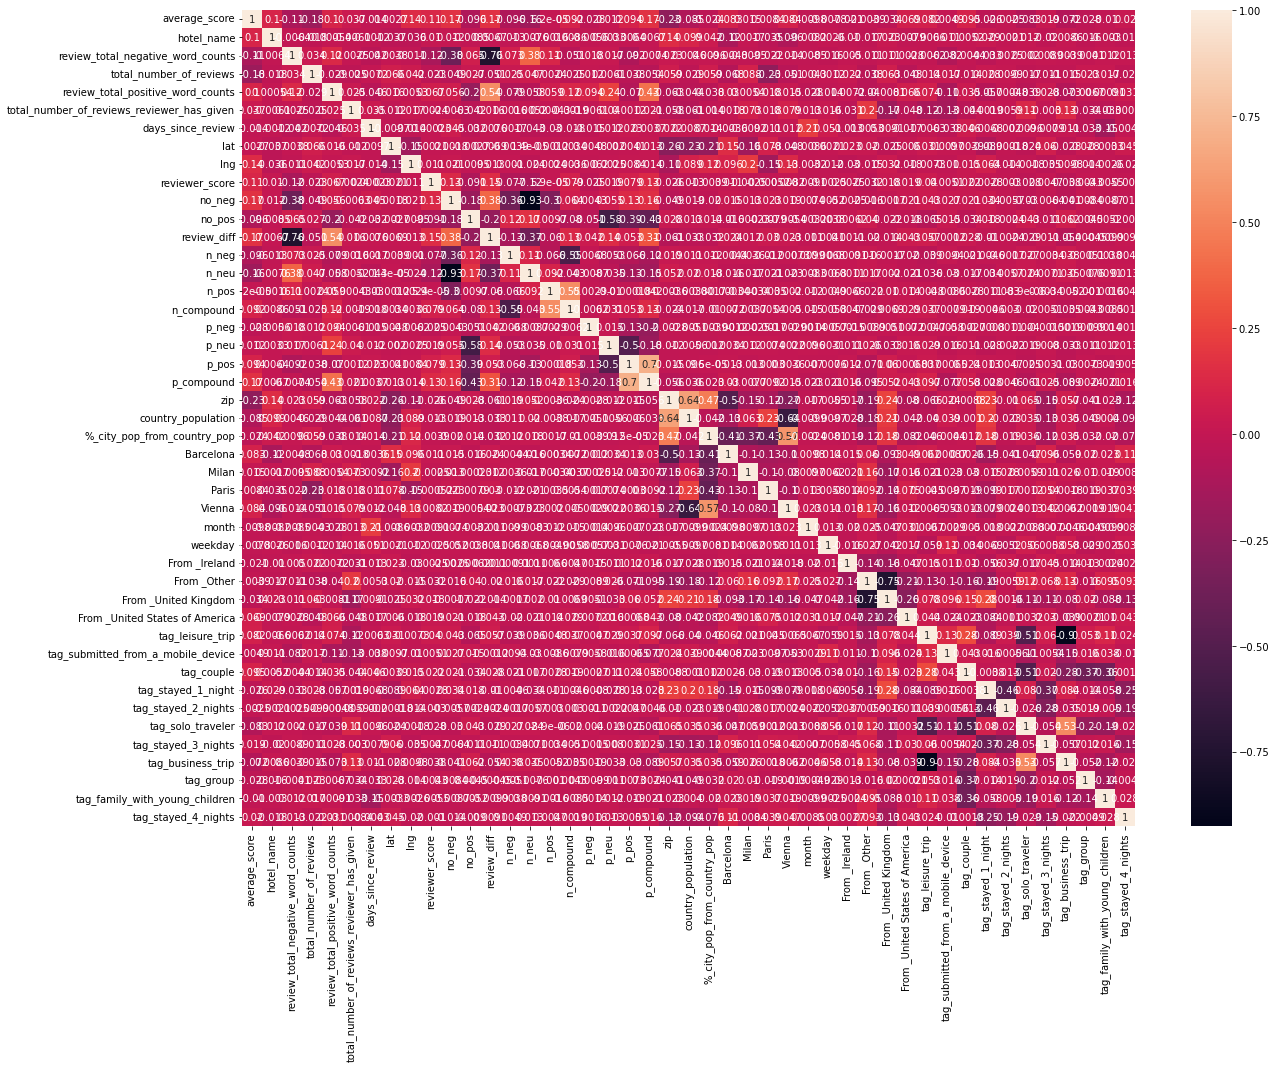

In [22]:
plt.rcParams['figure.figsize'] = (20,15)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [23]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [24]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [25]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 45), (386496, 45), (386496, 44), (309196, 44), (77300, 44))

In [26]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [27]:
%%time
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s


Wall time: 5min 27s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.4s finished


In [28]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE: {}.'.format(round(metrics.mean_absolute_error(y_test, y_pred)*100, 4)))
print('MAPE: {}.'.format(round(metrics.mean_absolute_percentage_error(y_test, y_pred)*100, 4)))

MAE: 85.9381.
MAPE: 12.259.


<AxesSubplot:>

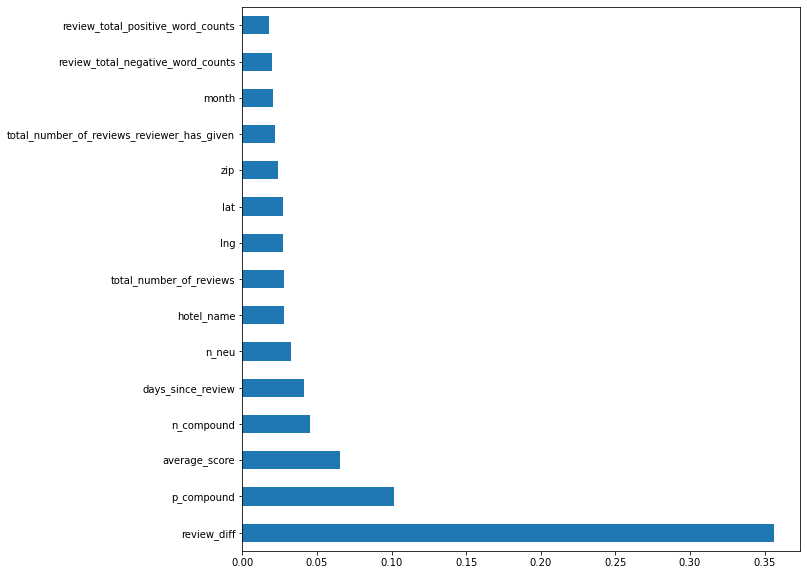

In [29]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [30]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [31]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [32]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.0s finished


In [33]:
predict_submission

array([8.629, 6.788, 8.074, ..., 8.034, 9.467, 7.501])

In [34]:
list(sample_submission)

['reviewer_score', 'id']

In [35]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_fin.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.629,488440
1,6.788,274649
2,8.074,374688
3,9.755,404352
4,9.493,451596
5,8.846,302161
6,7.612,317079
7,7.895,13963
8,8.648,159785
9,7.637,195089


In [36]:
sample_submission

,reviewer_score,id
0,8.629,488440
1,6.788,274649
2,8.074,374688
3,9.755,404352
4,9.493,451596
...,...,...
128930,8.897,495812
128931,9.374,315577
128932,8.034,511968
128933,9.467,303386
